# Graphical Analysis of GitHub Repositories and Contributors

In this notebook, we programatically view the connections between open source projects, determine project clusters, and map out technology ecosystems. We explore the Augur GitHub data to view relationships between open source projects and communities by studying graphs based on relations such as common contributors and project activities between different GitHub repositories.

## Connect to Augur database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd
import collections
from functools import reduce

import sqlalchemy as salc
import json
import os
import networkx as nx
import matplotlib.pyplot as plt

with open("../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Retrieve Available Repositories

In [3]:
# Subset repositories based on a category
# Selecting repositories that fall under the Containers org on Github

repo_git_set = ['https://github.com/containers/storage',
'https://github.com/containers/image',
'https://github.com/containers/skopeo',
'https://github.com/containers/crun',
'https://github.com/containers/fuse-overlayfs',
'https://github.com/containers/common',
'https://github.com/containers/container-selinux',
'https://github.com/containers/bubblewrap',
'https://github.com/containers/toolbox',
'https://github.com/containers/udica',
'https://github.com/containers/libkrun',
'https://github.com/containers/conmon',
'https://github.com/containers/podman-py']
repo_set = []
repo_name_set = []

In [4]:
for repo_git in repo_git_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id,
                    b.repo_name
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_git = \'{repo_git}\'
        """)

    t = engine.execute(repo_query)
    results = t.mappings().all()[0]
    repo_id = results['repo_id']
    repo_name = results['repo_name']
    repo_set.append(repo_id)
    repo_name_set.append(repo_name)
print(repo_set)
print(repo_name_set)

[27047, 27044, 27017, 27029, 27043, 27028, 27041, 27032, 27036, 27022, 27034, 27033, 27020]
['storage', 'image', 'skopeo', 'crun', 'fuse-overlayfs', 'common', 'container-selinux', 'bubblewrap', 'toolbox', 'udica', 'libkrun', 'conmon', 'podman-py']


### Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [52]:
issue_contrib = pd.DataFrame()
for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                i.cntrb_id,
                i.issue_id
                FROM
                repo r, issues i
                 WHERE
                i.repo_id = \'{repo_id}\' AND
                i.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    issue_contrib = pd.concat([issue_contrib, df_current_repo])

issue_contrib = issue_contrib.reset_index()
issue_contrib.drop("index", axis=1, inplace=True)
issue_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'issue_id']
display(issue_contrib)
issue_contrib.dtypes

,repo_id,repo_git,cntrb_id,issue_id
0,27047,https://github.com/containers/storage,NaN,294412
1,27047,https://github.com/containers/storage,NaN,294421
2,27047,https://github.com/containers/storage,NaN,294423
3,27047,https://github.com/containers/storage,NaN,294425
4,27047,https://github.com/containers/storage,NaN,294440
...,...,...,...,...
9561,27020,https://github.com/containers/podman-py,2208867.0,296191
9562,27020,https://github.com/containers/podman-py,2244791.0,296195
9563,27020,https://github.com/containers/podman-py,NaN,2636277
9564,27020,https://github.com/containers/podman-py,NaN,2636279


repo_id       int64
repo_git     object
cntrb_id    float64
issue_id      int64
dtype: object

### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [53]:
pr_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                prm.cntrb_id,
                prm.pull_request_id
                FROM
                repo r, pull_request_meta prm
                WHERE
                prm.repo_id = \'{repo_id}\' AND
                prm.repo_id = r.repo_id
                LIMIT 50000
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    pr_contrib = pd.concat([pr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
pr_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'pull_request_id']
display(pr_contrib)
pr_contrib.dtypes

,repo_id,repo_git,cntrb_id,pull_request_id
0,27047,https://github.com/containers/storage,63501,367640
1,27047,https://github.com/containers/storage,57932,367641
2,27047,https://github.com/containers/storage,2207432,367641
3,27047,https://github.com/containers/storage,26450,367639
4,27047,https://github.com/containers/storage,2207432,367639
...,...,...,...,...
12755,27020,https://github.com/containers/podman-py,2207432,1684531
12756,27020,https://github.com/containers/podman-py,61916,1684532
12757,27020,https://github.com/containers/podman-py,2207432,1684532
12758,27020,https://github.com/containers/podman-py,2244797,1684529


repo_id             int64
repo_git           object
cntrb_id            int64
pull_request_id     int64
dtype: object

### Retrieve PR Reviewers

We will now fetch all the PR Reviewers for various repositories.

In [54]:
prr_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                prr.cntrb_id,
                prr.pull_request_id
                FROM
                repo r, pull_request_reviews prr
                WHERE
                prr.repo_id = \'{repo_id}\' AND
                prr.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    prr_contrib = pd.concat([prr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
prr_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'pull_request_id']
display(prr_contrib)
prr_contrib.dtypes

,repo_id,repo_git,cntrb_id,pull_request_id


repo_id            object
repo_git           object
cntrb_id           object
pull_request_id    object
dtype: object

### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [55]:
commit_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                ca.cntrb_id,
                c.cmt_id
                FROM
                repo r, commits c, contributors_aliases ca
                WHERE
                c.repo_id = \'{repo_id}\' AND
                c.repo_id = r.repo_id and
                c.cmt_committer_email = ca.alias_email
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    commit_contrib = pd.concat([commit_contrib, df_current_repo])

commit_contrib = commit_contrib.reset_index()
commit_contrib.drop("index", axis=1, inplace=True)
commit_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'cmt_id']
display(commit_contrib)
commit_contrib.dtypes

,repo_id,repo_git,cntrb_id,cmt_id
0,27047,https://github.com/containers/storage,35421,155844022
1,27047,https://github.com/containers/storage,35421,155910822
2,27047,https://github.com/containers/storage,35421,155896125
3,27047,https://github.com/containers/storage,35421,155907333
4,27047,https://github.com/containers/storage,31088,155880004
...,...,...,...,...
127380,27020,https://github.com/containers/podman-py,2204264,94750801
127381,27020,https://github.com/containers/podman-py,2204264,94750805
127382,27020,https://github.com/containers/podman-py,2204264,94750806
127383,27020,https://github.com/containers/podman-py,2204264,94750787


repo_id      int64
repo_git    object
cntrb_id     int64
cmt_id       int64
dtype: object

## Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

### Commit Contributor Graph

In [110]:
df_commit = commit_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
df_commit.head()

cntrb_id,25451,25467,25571,25770,26261,26450,26519,26542,26648,26650,...,2555745,2555746,2555747,2555750,2555751,2555752,2555753,2555755,2555756,2555757
repo_id,,,,,,,,,,,,,,,,,,,,,
27017,0,0,0,0,0,165,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27028,0,0,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27029,0,0,0,0,82,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In the above dataframe, each row represents a repository ID and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_commit`, each contribution represents a commit. A value 0 means that a particular contributor has made no commits to the repository, and a a number x means that the contributor has made x number of commits to the repository.

In [111]:
df_commit = df_commit.reset_index()

In [112]:
df_commit.head()

cntrb_id,repo_id,25451,25467,25571,25770,26261,26450,26519,26542,26648,...,2555745,2555746,2555747,2555750,2555751,2555752,2555753,2555755,2555756,2555757
0,27017,0,0,0,0,0,165,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,27020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,27022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27028,0,0,0,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,27029,0,0,0,0,82,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
df_melted_commit = df_commit.melt(
    ['repo_id'],
    var_name = 'cntrb_id',value_name='number')

In [114]:
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
df_melted_commit.head()

,repo_id,cntrb_id,number
11,27044,25451,1
22,27041,25467,2
38,27047,25571,46
51,27047,25770,1
56,27029,26261,82


In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

In [115]:
G = nx.from_pandas_edgelist(df_melted_commit, 
                            source='repo_id',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [119]:
nodes = G.nodes()

In [120]:
Repo_id = df_melted_commit['repo_id'].to_list()
contributor_id = df_melted_commit['cntrb_id'].to_list()
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

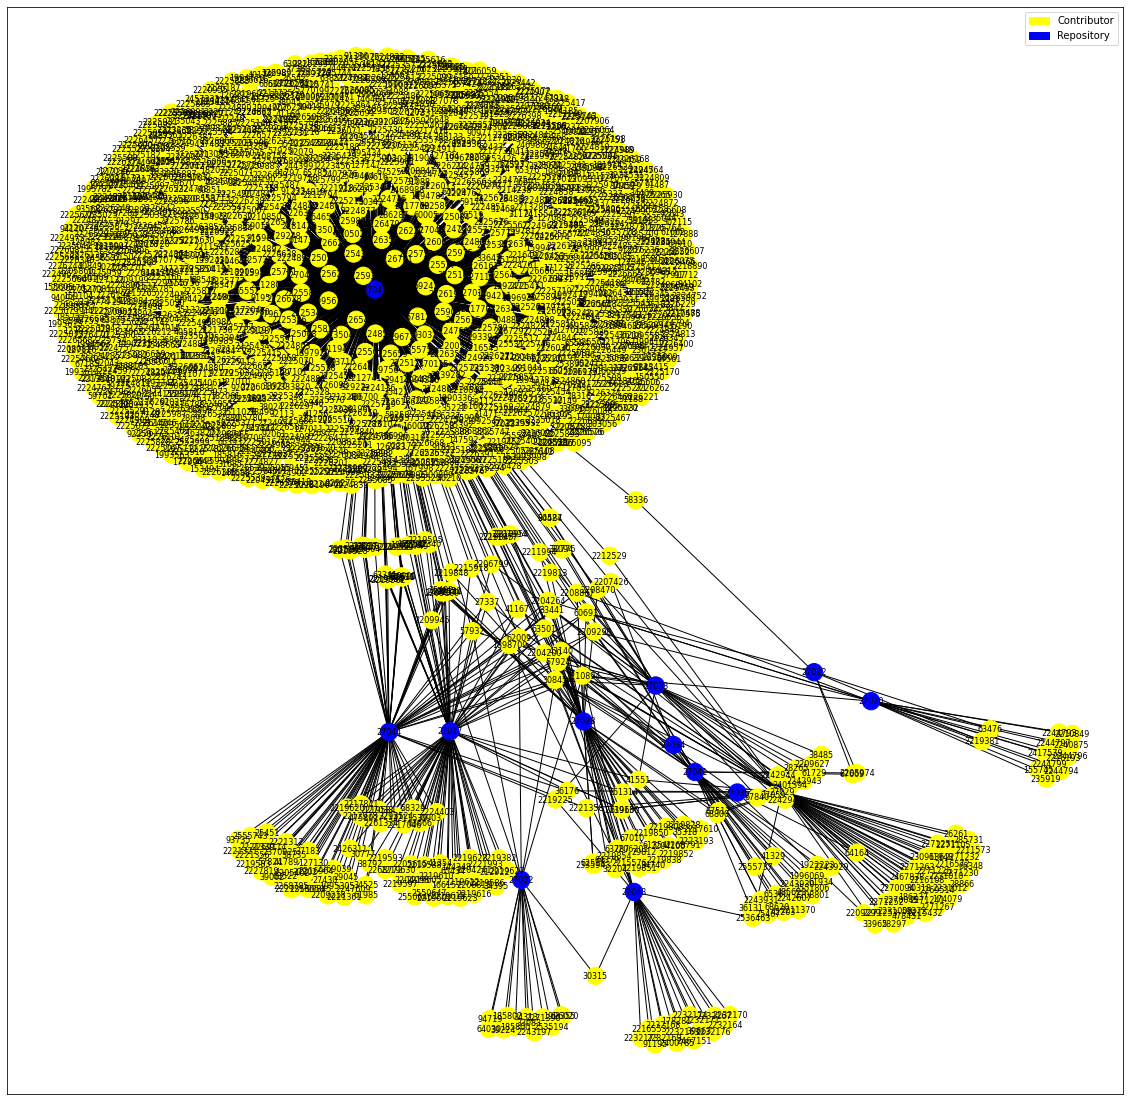

In [135]:
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Repository')
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

What we see above is a certain set of repositories and thier contributors plotted on the same graph. The blue dots represent project repositories and the yellow dots represent their contributors. This gives us an idea of central projects which have a large number of contributors and how other projects are connected to them. However, just given the number of repositories, this graph is hard to dig into, so lets subset this graph to create a smaller plot.

In [161]:
#subsetting the first 50 repo nodes for a smaller plot
smaller_df_melted_commit = df_melted_commit[0:50]

Here, we narrow down the entire set of nodes into view only 50 nodes plotted on a graph. Note, this is just for visual simplicilty. This is not a logical filtering and not all contributors for a project are going to be seen on the same plot

In [162]:
G = nx.from_pandas_edgelist(smaller_df_melted_commit, 
                            source='repo_id',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [163]:
nodes = G.nodes()

In [164]:
Repo_id = smaller_df_melted_commit['repo_id'].to_list()
contributor_id = smaller_df_melted_commit['cntrb_id'].to_list()
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

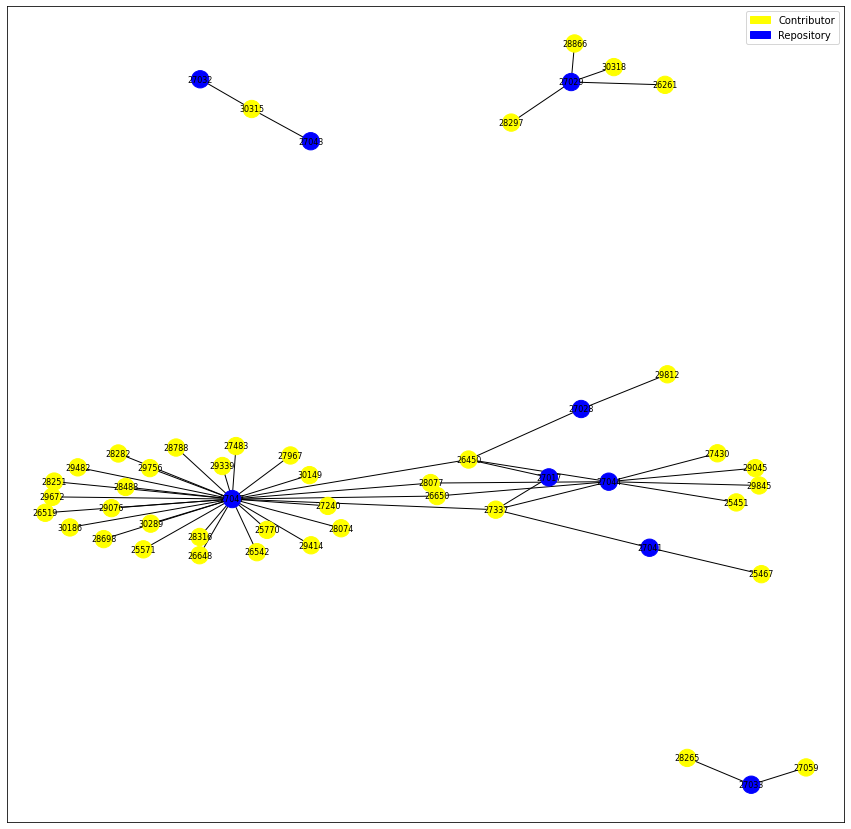

In [165]:
fig, ax = plt.subplots(figsize=(15,15))
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

### Issue Contributor Graph

We plot the plots similar to above on issue type contribution.

In [166]:
df_issue = issue_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
df_issue.head()

cntrb_id,25442.0,25512.0,25546.0,25571.0,25639.0,25731.0,25799.0,26261.0,26450.0,26761.0,...,2557848.0,2557855.0,2557857.0,2563210.0,2564787.0,2567546.0,2570082.0,2570084.0,2576890.0,2576892.0
repo_id,,,,,,,,,,,,,,,,,,,,,
27017,3,0,1,1,10,0,0,0,5,2,...,0,0,0,0,0,1,1,0,0,0
27020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27029,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27032,0,0,0,0,0,2,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


In [167]:
df_issue = df_issue.reset_index()

In [168]:
df_issue.head()

cntrb_id,repo_id,25442.0,25512.0,25546.0,25571.0,25639.0,25731.0,25799.0,26261.0,26450.0,...,2557848.0,2557855.0,2557857.0,2563210.0,2564787.0,2567546.0,2570082.0,2570084.0,2576890.0,2576892.0
0,27017,3,0,1,1,10,0,0,0,5,...,0,0,0,0,0,1,1,0,0,0
1,27020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,27022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27029,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,27032,0,0,0,0,0,2,0,0,0,...,1,0,0,0,0,0,0,1,1,0


In [169]:
df_melted_issue = df_issue.melt(
    ['repo_id'],
    var_name = 'cntrb_id',value_name='number')

In [170]:
df_melted_issue = df_melted_issue[df_melted_issue[df_melted_issue.columns[2]] != 0]
df_melted_issue.head()

,repo_id,cntrb_id,number
0,27017,25442.0,3
19,27036,25512.0,1
24,27017,25546.0,1
36,27017,25571.0,1
48,27017,25639.0,10


In [171]:
Repo_id = df_melted_issue['repo_id'].to_list()
contributor_id = df_melted_issue['cntrb_id'].to_list()

In [172]:
G = nx.from_pandas_edgelist(df_melted_issue, 
                            source='repo_id',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [173]:
nodes = G.nodes()

In [174]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

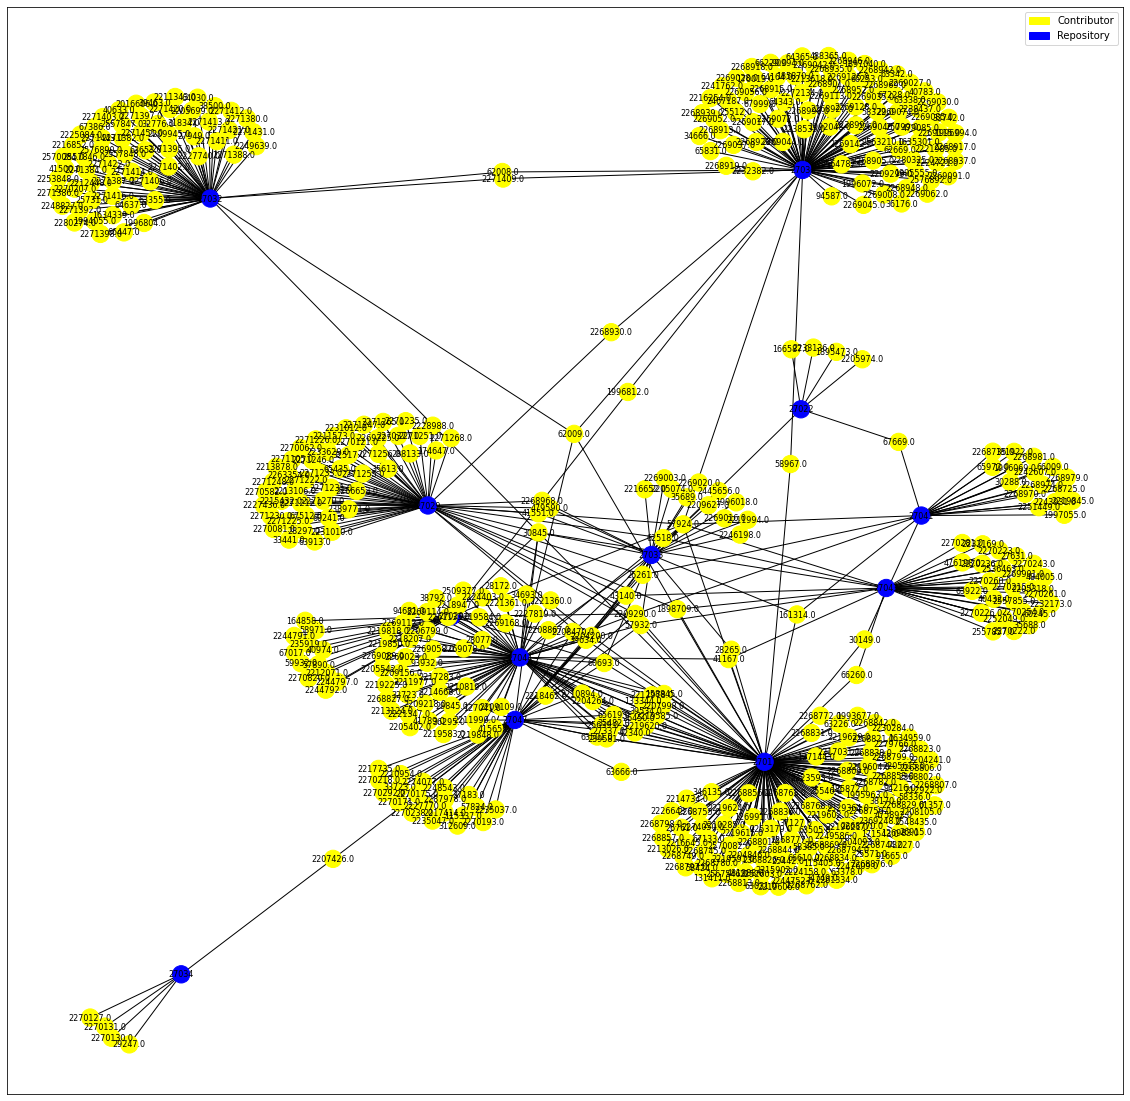

In [175]:
fig, ax = plt.subplots(figsize=(20,20))
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

### PR Contributor Graph

We now plot similar graphs as above for Pull Request type contributors

In [177]:
df_pr = pr_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
df_pr.head()

cntrb_id,25447,25450,25451,25546,25571,26114,26450,26650,26723,27337,...,2570101,2570138,2576928,2579219,2579343,2579390,2579391,2579475,2579481,2579485
repo_id,,,,,,,,,,,,,,,,,,,,,
27017,0,0,0,0,2,0,10,0,0,106,...,0,0,0,0,0,0,0,1,1,1
27020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27028,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
27029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
df_pr = df_pr.reset_index()

In [179]:
df_melted_pr = df_pr.melt(
    ['repo_id'],
    var_name = 'cntrb_id',value_name='number')

In [180]:
df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]
df_melted_pr.head()

,repo_id,cntrb_id,number
8,27036,25447,1
18,27032,25450,1
37,27044,25451,1
50,27044,25546,2
52,27017,25571,2


In [181]:
Repo_id = df_melted_issue['repo_id'].to_list()
contributor_id = df_melted_issue['cntrb_id'].to_list()

In [182]:
G = nx.from_pandas_edgelist(df_melted_pr, 
                            source='repo_id',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [183]:
nodes = G.nodes()

In [184]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

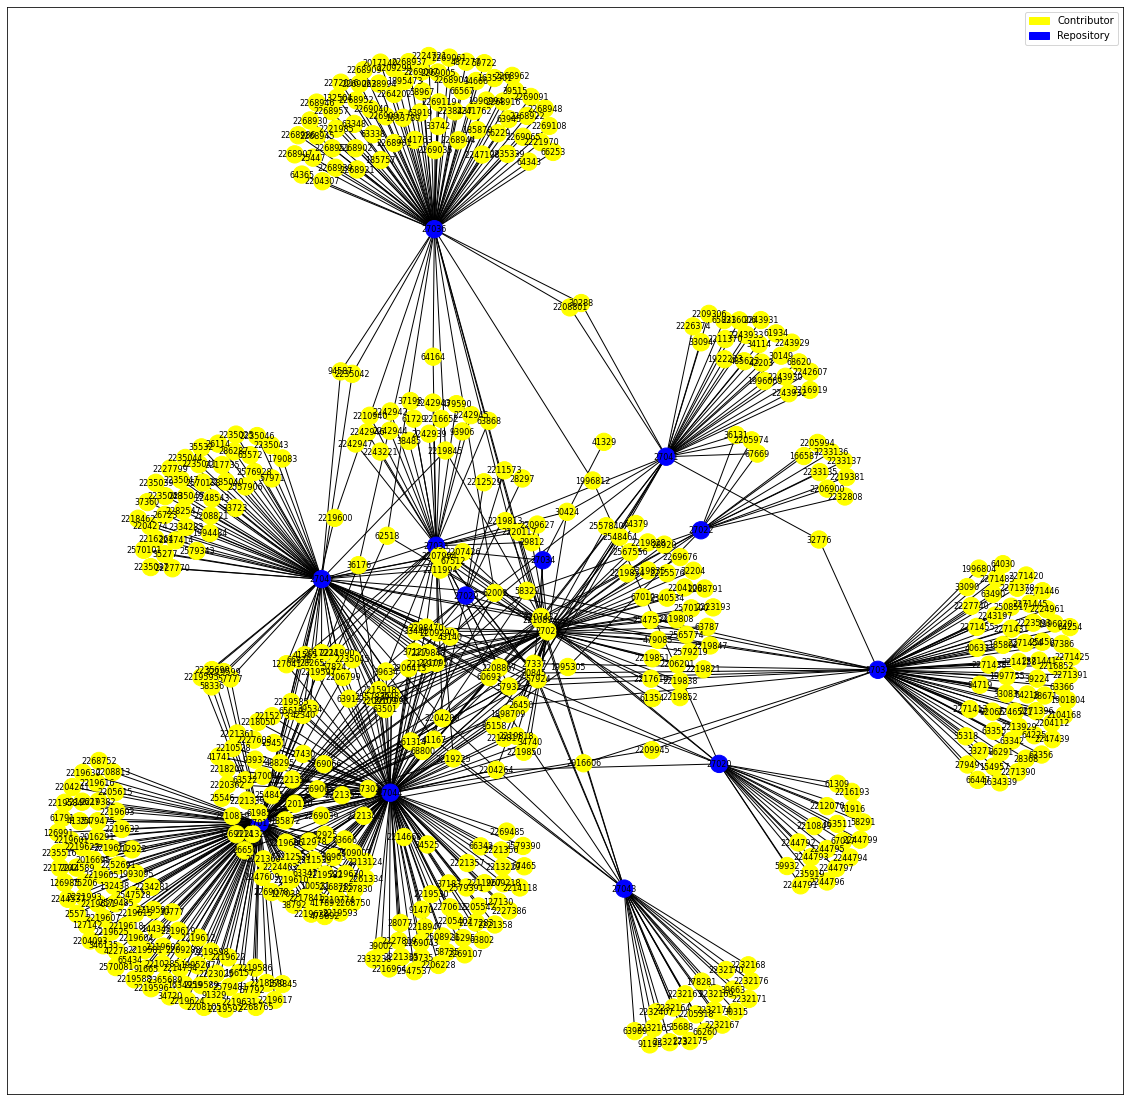

In [185]:
fig, ax = plt.subplots(figsize=(20,20))
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

## Nodes as projects edges as contributors

In this section, we represent data in a different way and try out another graph representation where the project repositories are represented by nodes and the edges are shared contributions between those projects

Lets pick the **Pull Request** type contribution for these graph plots as an example

In [186]:
df_melted_pr.head()

,repo_id,cntrb_id,number
8,27036,25447,1
18,27032,25450,1
37,27044,25451,1
50,27044,25546,2
52,27017,25571,2


In [187]:
contributorGraph = {}
for i, row in df_melted_pr.iterrows():
    if row['cntrb_id'] not in contributorGraph:
        contributorGraph[row['cntrb_id']] = []
    if(row['number'] > 0):
        contributorGraph[row['cntrb_id']].append((row['repo_id'], row['number']))

In [193]:
list(contributorGraph.items())[:10]

[(25447, [(27036, 1)]),
 (25450, [(27032, 1)]),
 (25451, [(27044, 1)]),
 (25546, [(27044, 2)]),
 (25571, [(27017, 2)]),
 (26114, [(27047, 2)]),
 (26450, [(27017, 10), (27028, 1), (27032, 1), (27044, 10), (27047, 2)]),
 (26650, [(27044, 2)]),
 (26723, [(27047, 1)]),
 (27337, [(27017, 106), (27032, 1), (27041, 1), (27044, 90), (27047, 4)])]

`contributorGraph` above is a dictionary where each key is a project repository, and the value is a list of **"connected"** project repositories and the number of **"shared connections"** between them. Lets explain **"connected"** repositories and shared "connections".

structure of `contributorGraph` =  
{  
`repo1`: [(`repo2`, `PRs by same authors in repo 1 and repo 2`)],  
 `repo2`: [(`repo4`, `PRs created by same authors in repo 1 and repo 4` ), (`repo5`, `PRs by same authors in repo 2 and repo 5`)]  
}

**"shared connections"** constitute of *commits*, *pull requests*, *issues* and *pull request reviews* that are made by the same contributor.
We will call 2 project repositories **"connected"** if they have a **"shared connection"** between them. 
This means if they have a contributor who makes a *commit*, *pull request*, *issue* or *pull request review* in both the repositories, they count as a shared contributor and the repositories are connected. 

We track the number of shared contributions between 2 repositories for creating this graph plot.

In [195]:
commonRepoContributionsByContributor = collections.defaultdict(int)
for key in contributorGraph:
    if len(contributorGraph[key])-1 <= 0:
        continue
    for repoContributionIndex in range(len(contributorGraph[key])-1):
        commonRepoContributionsByContributor[(contributorGraph[key][repoContributionIndex][0], contributorGraph[key][repoContributionIndex+1][0])] += contributorGraph[key][repoContributionIndex][1]+contributorGraph[key][repoContributionIndex+1][1]
print(commonRepoContributionsByContributor)

defaultdict(<class 'int'>, {(27017, 27028): 1132, (27028, 27032): 344, (27032, 27044): 46, (27044, 27047): 4832, (27017, 27032): 189, (27032, 27041): 6, (27041, 27044): 123, (27017, 27033): 76, (27028, 27033): 276, (27036, 27041): 716, (27033, 27041): 31, (27028, 27029): 1482, (27029, 27032): 410, (27032, 27033): 552, (27033, 27034): 289, (27034, 27041): 4, (27041, 27043): 458, (27043, 27044): 2115, (27017, 27044): 157, (27033, 27044): 275, (27028, 27044): 610, (27022, 27041): 30, (27017, 27036): 9, (27036, 27044): 17, (27017, 27029): 6, (27029, 27043): 3, (27028, 27034): 39, (27034, 27044): 10, (27017, 27047): 19, (27017, 27022): 3, (27022, 27032): 3, (27032, 27036): 72, (27017, 27020): 1683, (27020, 27022): 208, (27022, 27028): 1406, (27028, 27036): 6, (27033, 27036): 147, (27028, 27047): 5, (27036, 27047): 14, (27017, 27041): 5, (27022, 27044): 2, (27020, 27036): 4, (27033, 27043): 14, (27020, 27028): 68, (27029, 27044): 4, (27034, 27047): 25, (27034, 27036): 650, (27029, 27033): 99

`commonRepoContributionsByContributor` is a nested dictionary consisting of dictionaries of repository pairs and their common contributions. 

structure of `commonRepoContributionsByContributor` =  
{  
(`repo1, repo2`): `PRs by same authors in repo 1 and repo 2`,  
(`repo2, repo4`): `PRs by same authors in repo 2 and repo 4`,  
(`repo2, repo5`): `PRs by same authors in repo 2 and repo 5`,   
}

In [197]:
res = []
for key in commonRepoContributionsByContributor:
    res.append(tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],))

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [200]:
g = nx.Graph()
g.add_weighted_edges_from(res)

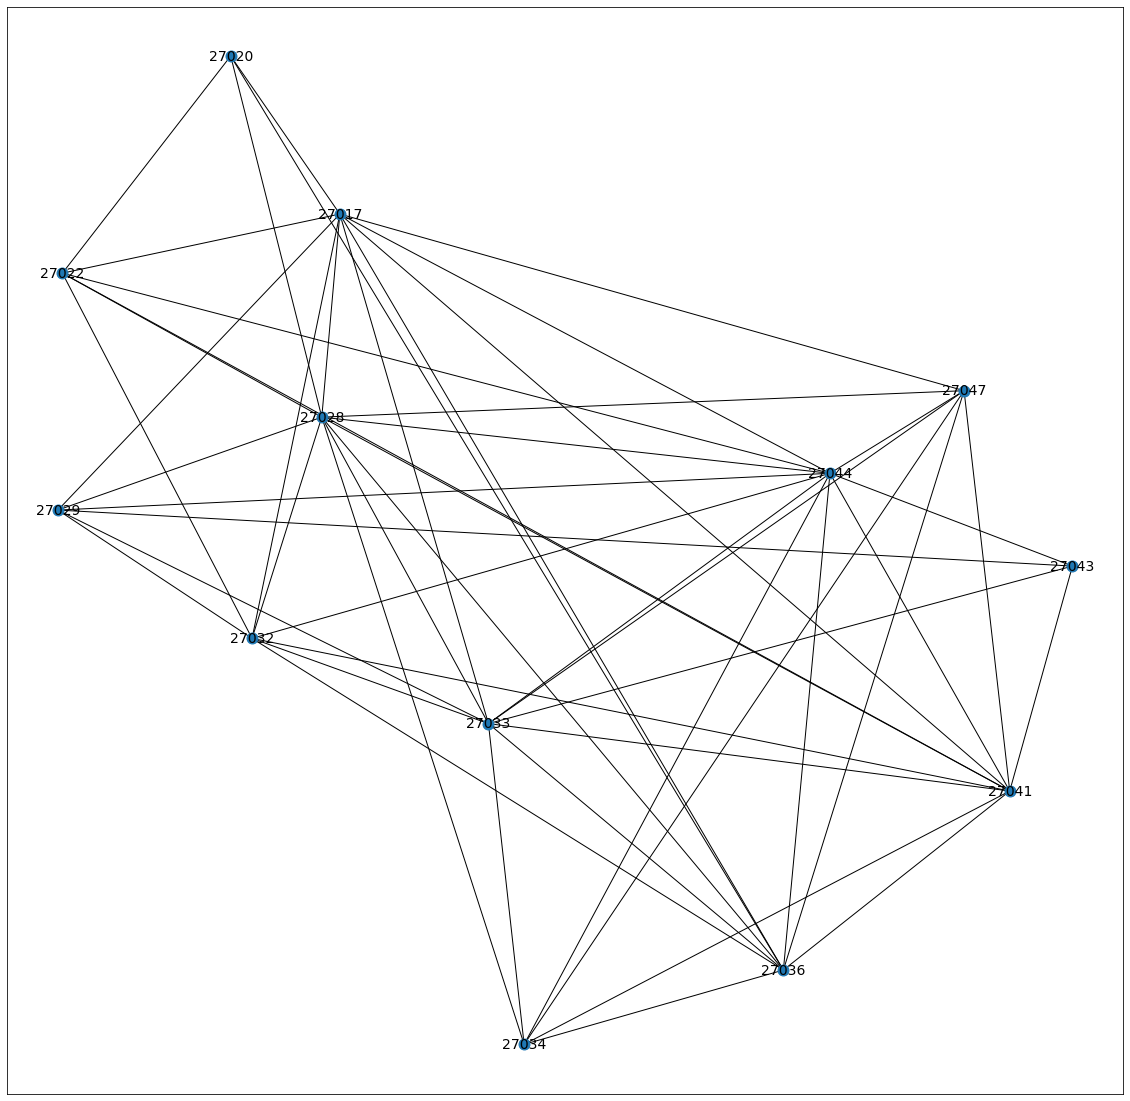

In [201]:
fig, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx(g, node_size=120, font_size=14, ax=ax)


The above graph represents project repositories and how close or far they are to each other based on their degree of connected (number of shared contributions amongst them). If 2 nodes are close to each other, the 2 projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We are not plotting lone projects in this graph as we want to identify project repositories in connection to existing known repositories.  
Note: this is not a complete (fully-connected) graph. All projects are not **"connected"** to each project. See above for the definition of **"connected"** 

## Conclusion

In this notebook, we created initial graph representations of existing open source GitHub repositories falling under a certain category using [NetworkX](https://networkx.org/). 

We used 2 type of graph representations:

- One where repositories and contributors both are both nodes (differently colored). Viewing which repositories share which set of contributors and analyzing their clusters can give an idea about how projects are connected to each other and to what degree 
- One where repositories are nodes, and edges are number of contributions. The distance between repositories, how close or far they are will depend on the number of shared contributions that exist between them.